<a href="https://colab.research.google.com/github/shubhamwagh/nerf-toy/blob/main/notebook/demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook, let's try fitting a function to produce the image as a function of (X,Y) image coordinates.

More details can be found [here](https://github.com/shubhamwagh/nerf-toy/blob/main/README.md).

In [ ]:
!pip install nerf-toy

In [9]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from nerf_toy.data_loader import DataLoader
from nerf_toy.transforms import BasicEncodingTransform, PositionalEncodingTransform, GaussianFourierFeatureTransform
from nerf_toy.model import base_model
from nerf_toy.callback import PredictionVideoSaverCallback, PlotLossesAndMetricsCallback
from nerf_toy.metrics import PSNR, SSIM
from nerf_toy.utils import arr_to_image

In [10]:
img_url = "https://unsplash.com/photos/MMRd58Fo_Mk/download?force=true&w=640"

In [13]:
basic_transform = BasicEncodingTransform() # Basic Mapping
poistional_encoding= PositionalEncodingTransform(multires=10) # Positional Encoding
fourier_feature_transform = GaussianFourierFeatureTransform(num_input_channels=2, mapping_size=128, scale=10) # Gaussian Fourier Feature Mapping

In [14]:
loader = DataLoader(uri=img_url, transform=fourier_feature_transform) # default transform=None means no mapping

(1, 640, 640, 256)
(1, 640, 640, 3)


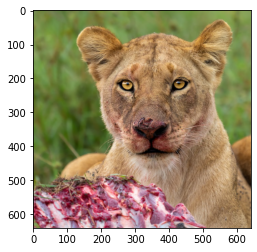

In [15]:
yx_grid, target = loader.load_data()
print(yx_grid.shape)
print(target.shape)

plt.imshow(target[0])
plt.show()

# Model and training code

Our model is a coordinate-based multilayer perceptron. In this example, for each input image coordinate $(x,y)$, the model predicts the associated color $(r,g,b)$.

![Network diagram](https://raw.githubusercontent.com/shubhamwagh/nerf-toy/main/misc/network_diagram.png)

Note: we use 2D convolutions with a kernel size of (1, 1), which act as "pointwise" convolutions. This is equivalent to a densely connected multilayer perceptron for each coordinate. 

Also, we use batchnorm to speed up convergence.

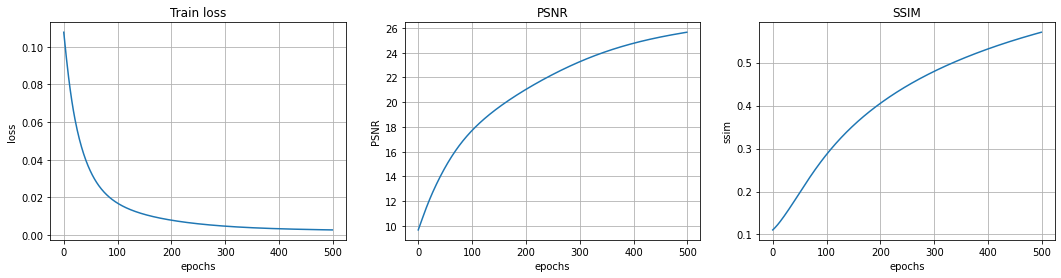

Saving training convergence video.....
Saved training convergence video as /content/training_convergence_0.mp4


In [16]:
net = base_model(input_shape=yx_grid.shape[1:], output_dim=3, num_layers=4, num_channels=256) # basic nerf toy model

loss = 'mse'
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

psnr_metric = PSNR(max_value=1.0) # peak signal-to-noise ratio
ssim_metric = SSIM(max_value=1.0) # structured-similarity index

video_callback = PredictionVideoSaverCallback(yx_grid, target, every=1, video_path='/content') # Video frames saver callback
plot_callback = PlotLossesAndMetricsCallback() # Plot losses anad metrics callback

net.compile(optimizer=optimizer, loss=loss, metrics=[psnr_metric, ssim_metric])

hist = net.fit(x=yx_grid, y=target, epochs=500, verbose=0, callbacks=[video_callback, plot_callback])

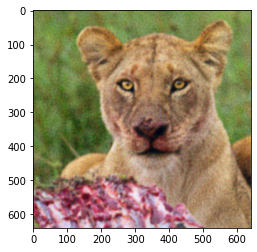

In [17]:
# Inference using trained model
generated = net(yx_grid, training=False)
plt.imshow(arr_to_image(generated[0]))
plt.show()

In [18]:
# Display video inline
file = video_callback.saved_path
from IPython.display import HTML
from base64 import b64encode
mp4 = open(file, 'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML(f'''
<video width=256 controls autoplay loop>
      <source src="{data_url}" type="video/mp4">
</video>''')